# Ejemplo de resolución del problema de Poisson con distintas condiciones de contorno y manipulación de la solución para el problema de cálculo de capacitancias #


El problema a resolver es:


\begin{eqnarray*}
-\Delta u &=& f \;\;\;\;\; \mbox{in } \Omega \\
u &=& g \;\;\;\;\; \mbox{in } \partial \Omega_{int} \\
\hat{n} \cdot \nabla u &=& h \;\;\;\;\; \mbox{in } \partial \Omega_{ext} \\
\end{eqnarray*}

Para ello impondremos la versión débil del mismo:

Encuentre $u$ en $H^1(\Omega, f))$ (o sea con las condiciones de contorno de Dirichlet en $\partial \Omega_{int}$) tal que,

$$
\int_{\Omega} \nabla v \cdot \nabla u \; d\Omega 
- \int_{\Omega} v \; f \; d\Omega 
- \oint_{\Omega_{ext}} v \; h \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Si obtenemos un $u$ satisfaciendo esta ecuación, y es suficientemente suave, entonces podemos integrar por partes el primer término y obtener:

$$
\int_{\Omega}  v \; (-\Delta u - f) \; d\Omega 
+ \oint_{\Omega_{ext}} v \; (\hat{n} \cdot u - h) \; d\Gamma 
= 0 \;\;\;\;\; \forall v \;\; \in H^1_0(\Omega)
$$

Tomando $v$ arbitrario pero de soporte compacto vemos que $u$ debe satisfacer:

$$
-\Delta u = f \;\;\;\;\; \mbox{in } \Omega,
$$
y tomando $v$ arbitrario vemos que también se debe cumplir la condición de Neumann,

$$
\hat{n} \cdot \nabla u = h \;\;\;\;\; \mbox{in } \partial \Omega_{ext}.
$$

La condición de Dirichlet es automática por la elección del espacio.

Luego utilizaremos la solución encontrada para un problema de capacitancia.




Para resolver el problema utilizaremos la infraestructura del paquete `Gridap.jl` de Julia. Este ejemplo es una recopilación de varios ejemplos en el tutorial del paquete. 

In [1]:
using Gridap
using GridapMakie, GLMakie #Para graficar 
using FileIO #Gráficos y salidas
#mkdir("models")
#mkdir("images")
using GridapGmsh

Vamos a usar una grilla previamente construida con la librería `gmsh`. En el directorio `models` encontrarán un *script* con terminación `.geo` (rectangle_hole_square.geo) que es el que se usó para construir el ejemplo. En base al mismo, y siguiendo el tutorial de `gmsh` podrán construir distintas grillas. También se pueden usar otras librerías para construir grillas. Estas se importan a la infraestructura **Gridap** y con ellas se construye la triangulación a usar. Notar que en el sript se dan nombres a las tres fronteras, la externa (rectangular), `"ext"` y las internas `"circle"` y `"square"`

In [2]:
res = 4 # 1, 2, o 4 (coarser to finer)
if res == 1
    model = GmshDiscreteModel("models/rectangle_hole_square_coarse.msh")
elseif res == 2
    model = GmshDiscreteModel("models/rectangle_hole_square_fine.msh")
elseif res == 4
    model = GmshDiscreteModel("models/rectangle_hole_square_finer.msh")
else println("resolution not implemented")
end

# grid parameters

L=[2.0; 1.0] # box corner (the other is at [0;0])
xc = [0.5; 0.5] # circle center
r = 0.25 # circle radius
xs = [1.5; 0.5] # square center
l = 0.25 # square half side
p = (L,xc, r, xs, l)

Info    : Reading 'models/rectangle_hole_square_finer.msh'...
Info    : 26 entities
Info    : 25167 nodes
Info    : 50336 elements
Info    : Done reading 'models/rectangle_hole_square_finer.msh'


([2.0, 1.0], [0.5, 0.5], 0.25, [1.5, 0.5], 0.25)

In [3]:
Ω = Triangulation(model)

UnstructuredGrid()

In [4]:
degree = 3
dΩ = Measure(Ω,degree)

Measure()

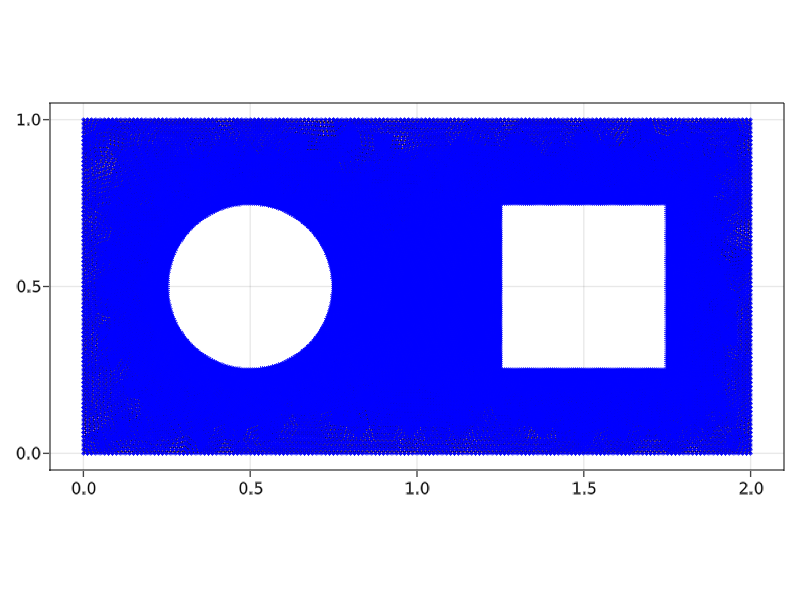

In [126]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(2)
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

Tambén podemos graficar los contornos:

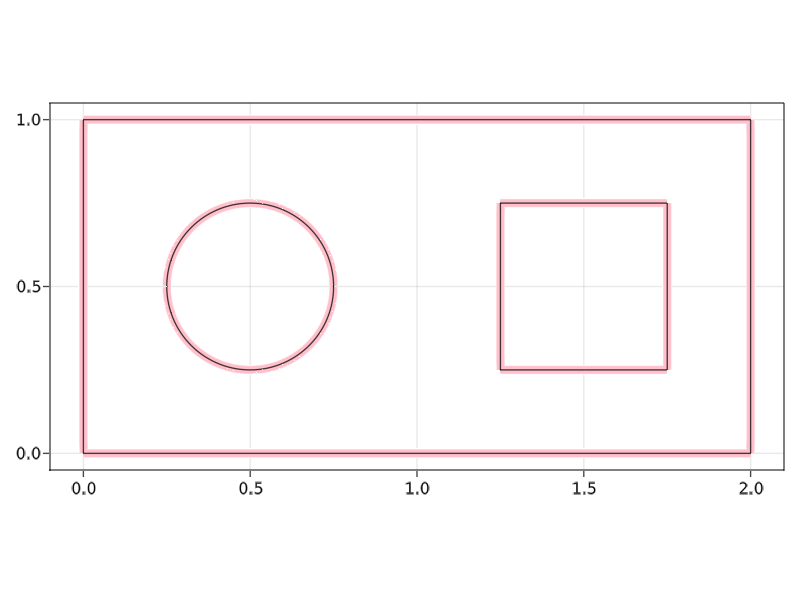

In [127]:
Γ = BoundaryTriangulation(model,tags=["ext", "circle", "square"])
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(2)
wireframe!(Γ, color=:black, linewidth=1)
fig

Vamos a elegir dos problemas simples para calcular la matríz de capacitancia de un conjunto de conductores. Tomaremos a los conductores como los dos cuerpos: el círculo y el cuadrado y pondremos condiciones de potencial constante. El borde externo se tomará como *infinito* y pondremos allí siempre potencial cero.

In [37]:
capacity_cs = false # potencial 1 en el círculo y potencial 0 en el cuadrado.
capacity_sc = false # potencial 0 en el círculo y potencial 1 en el cuadrado.
#capacity_cs = true
capacity_sc = true 

true

Una vez que tenemos el grillado comenzamos a definir los elementos finitos que utilizaremos. En este caso usaremos elementos lagrangiano de **orden 1** que cumplirán una condición de Dirichlet en la región $\partial \Omega_{int}$. Al construirse la grilla esta región ha sido marcada como la frontera interior del rectángulo con el `tag` `"int"`. 

In [38]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
dirichlet_tags=["circle", "square","ext"]
V = TestFESpace(model,reffe;conformity=:H1,dirichlet_tags = dirichlet_tags)
#V = TestFESpace(model,reffe;conformity=:L2,dirichlet_tags = dirichlet_tags) #no funciona la inversión. 

UnconstrainedFESpace()

Asignamos los valores de contorno para los potenciales. 

In [67]:
# internal Dirichlet boundary condition
g(x) = 1.0 # esta puede ser una función de x (vector posición)
if capacity_cs
    U = TrialFESpace(V,[g 0.0 0.0])
elseif capacity_sc
    U = TrialFESpace(V,[0.0 g 0.0])
end

TrialFESpace()

A continuación definimos el problema débil en forma abstracta:

In [68]:
f(x) = 0 # en este caso la fuente es cero, pero se puede poner una distribución de carga.

a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ  # en a(u,v) va toda la dependencia con u que es la incógnita. 

b(v) = ∫(v*f )*dΩ # aquí todo lo que es fuente. 


b (generic function with 1 method)

A partir de este punto el paquete **Gridap.jl** genera un sistema del tipo $Ax=b$ y lo resuelve para la versión elementos finitos de u.

In [69]:
op = AffineFEOperator(a,b,U,V)

AffineFEOperator()

In [70]:
ls = LUSolver()
solver = LinearFESolver(ls)

LinearFESolver()

In [71]:
uh = solve(solver,op)
#uh = solve(op)

SingleFieldFEFunction():
 num_cells: 49280
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 2747840976966688877

Ahora podemos graficar la solución encontrada y guardarla además en un archivo que se puede leer con paraview o visit.

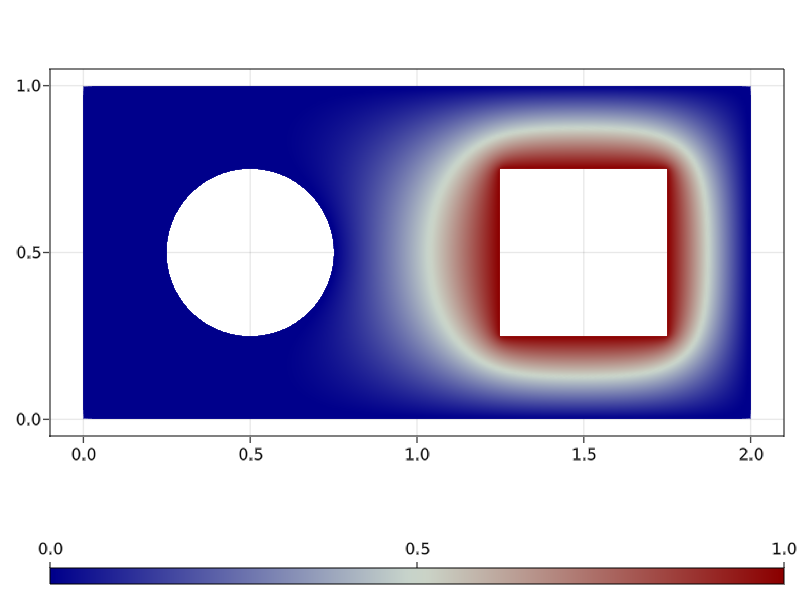

In [124]:
fig, ax, plt = plot(Ω, uh)
ax.aspect = AxisAspect(2)
Colorbar(fig[2,1], plt, vertical=false)
fig

In [73]:
if capacity_cs
    writevtk(Ω,"images/solucion_cs_$res",cellfields=["uh_cs_$res" => uh])
    writevtk(Ω,"images/grad_cs_$res",cellfields=["grad_uh_cs_$res" => ∇(uh)])
elseif capacity_sc
    writevtk(Ω,"images/solucion_sc_$res",cellfields=["uh_sc_$res" => uh])
    writevtk(Ω,"images/grad_cs_$res",cellfields=["grad_uh_cs_$res" => ∇(uh)])
end

(["images/grad_cs_4.vtu"],)

Una vez obtenida la solución se pueden calcular algunas cantidades físicamente interesantes, por ejemplo la carga contenida en una región. Aquí calculamos la carga en la región exterior y en la interior. Note el cambio de signo para la interior ya que la normal siempre es toma saliente.

Recordemos que la carga se define como: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  \frac{1}{4\pi}\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}

Mientras que la  **matriz de capacidades** como: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [74]:
Γ_ext = BoundaryTriangulation(model,tags="ext")
dΓ_ext = Measure(Γ_ext,degree)
nb_ext = get_normal_vector(Γ_ext)
Q_ext = -sum(∫((nb_ext ⋅ ∇(uh)))*dΓ_ext)/4/π

0.6866735427974108

In [75]:
Γ_square = BoundaryTriangulation(model,tags="square")
dΓ_square = Measure(Γ_square,degree)
nb_square = get_normal_vector(Γ_square)
Q_square = sum(∫((nb_square ⋅ ∇(uh)))*dΓ_square)/4/π

0.7467534095695912

In [76]:
Γ_circle = BoundaryTriangulation(model,tags="circle")
dΓ_circle = Measure(Γ_circle,degree)
nb_circle = get_normal_vector(Γ_circle)
Q_circle = sum(∫((nb_circle ⋅ ∇(uh)))*dΓ_circle)/4/π

-0.0569598899337284

In [77]:
Q_ext - Q_circle - Q_square # esto debería dar cero si no hay fuentes (cargas).

-0.00311997683845211

![Una imagen con visIt](images/visit0004.png)